In [46]:
import torch
import numpy as np   

In [47]:
import sys
import os
sys.path.insert(0, "/home/mafzhang/code/CHLA-Imputation-and-Prediction-for-Bay/")
print(sys.path)
from dataset.dataset_imputation import PRE8dDataset

['/home/mafzhang/code/CHLA-Imputation-and-Prediction-for-Bay/', '/home/mafzhang/code/CHLA-Imputation-and-Prediction-for-Bay/', '/home/mafzhang/miniconda3/envs/torch/lib/python39.zip', '/home/mafzhang/miniconda3/envs/torch/lib/python3.9', '/home/mafzhang/miniconda3/envs/torch/lib/python3.9/lib-dynload', '', '/home/mafzhang/.local/lib/python3.9/site-packages', '/home/mafzhang/miniconda3/envs/torch/lib/python3.9/site-packages']


In [48]:
import argparse
parser = argparse.ArgumentParser(description='Imputation')

# args for area and methods
parser.add_argument('--area', type=str, default='PRE', help='which bay area we focus')

# basic args
parser.add_argument('--epochs', type=int, default=500, help='epochs')
parser.add_argument('--batch_size', type=int, default=16, help='batch size')
parser.add_argument('--lr', type=float, default=1e-3, help='learning rate')
parser.add_argument('--wd', type=float, default=1e-4, help='weight decay')
parser.add_argument('--test_freq', type=int, default=500, help='test per n epochs')
parser.add_argument('--embedding_size', type=int, default=32)
parser.add_argument('--hidden_channels', type=int, default=32)
parser.add_argument('--diffusion_embedding_size', type=int, default=64)
parser.add_argument('--side_channels', type=int, default=1)

# args for tasks
parser.add_argument('--in_len', type=int, default=46)
parser.add_argument('--out_len', type=int, default=46)
parser.add_argument('--missing_ratio', type=float, default=0.1)

# args for diffusion
parser.add_argument('--beta_start', type=float, default=0.0001, help='beta start from this')
parser.add_argument('--beta_end', type=float, default=0.2, help='beta end to this')
parser.add_argument('--num_steps', type=float, default=50, help='denoising steps')
parser.add_argument('--num_samples', type=int, default=10, help='n datasets')
parser.add_argument('--schedule', type=str, default='quad', help='noise schedule type')
parser.add_argument('--target_strategy', type=str, default='random', help='mask')

# args for mae
parser.add_argument('--num_heads', type=int, default=8, help='n heads for self attention')
config = parser.parse_args([])

In [49]:
from torch.utils.data import DataLoader
test_dloader = DataLoader(PRE8dDataset(config, mode='test'), 1, shuffle=True)

In [50]:
datas, data_ob_masks, data_gt_masks, labels, label_masks = next(iter(test_dloader))
device = "cuda"
datas, data_ob_masks, data_gt_masks, labels, label_masks = datas.float().to(device), data_ob_masks.to(device), data_gt_masks.to(device), labels.to(device), label_masks.to(device)

In [51]:
model = torch.load("../../log/imputation/PRE/GraphDiffusion/best_0.1.pt")
model = model.to(device)

In [52]:
cond_mask = data_gt_masks
adj = np.load("/home/mafzhang/data/{}/8d/adj.npy".format(config.area))
adj = torch.from_numpy(adj).float().to(device)

In [53]:
imputed_data_our = model.impute(datas, cond_mask, adj, 10)
imputed_data_our = imputed_data_our.median(1).values
mask = data_ob_masks - cond_mask
imputed_our = imputed_data_our[0][mask.bool().cpu()[0]]
truth = datas[0][mask.bool()[0]].cpu()

In [54]:
mae = torch.load("../../log/imputation/PRE/MAE/best.pt")
is_sea = np.load("/home/mafzhang/data/PRE/8d/is_sea.npy")
datas_image = torch.zeros(1,46,1,60,96)
datas_image = datas_image.to(device)
datas_image[:,:,:,is_sea.astype(bool)]=datas
cond_mask_image = torch.zeros(1,46,1,60,96)
cond_mask_image = cond_mask_image.to(device)
cond_mask_image[:,:,:,is_sea.astype(bool)]=cond_mask
imputed_data_mae = mae.impute(datas_image, cond_mask_image)
imputed_data_mae = imputed_data_mae[:,:,:,is_sea.astype(bool)]

In [55]:
imputed_mae = imputed_data_mae[0][mask.bool().cpu()[0]]

In [56]:
from einops import rearrange
import torchcde
tmp_data = torch.where(cond_mask.cpu()==0, float("nan"), datas.cpu())
tmp_data = rearrange(tmp_data, "b t c n-> (b n) t c")
itp_data = torchcde.linear_interpolation_coeffs(tmp_data)
imputed_data_itp = rearrange(itp_data, "(b n) t c -> b t c n", b=datas.shape[0], n=datas.shape[-1])

In [57]:
imputed_itp = imputed_data_itp[0][mask.bool().cpu()[0]]

In [58]:
imputed_our = imputed_our[:1000]
imputed_mae = imputed_mae[:1000]
imputed_itp = imputed_itp[:1000]
truth = truth[:1000]

PearsonRResult(statistic=0.9939856714917412, pvalue=0.0)
PearsonRResult(statistic=0.9905275997717197, pvalue=0.0)
PearsonRResult(statistic=0.8602162055819825, pvalue=3.6526661893516265e-294)


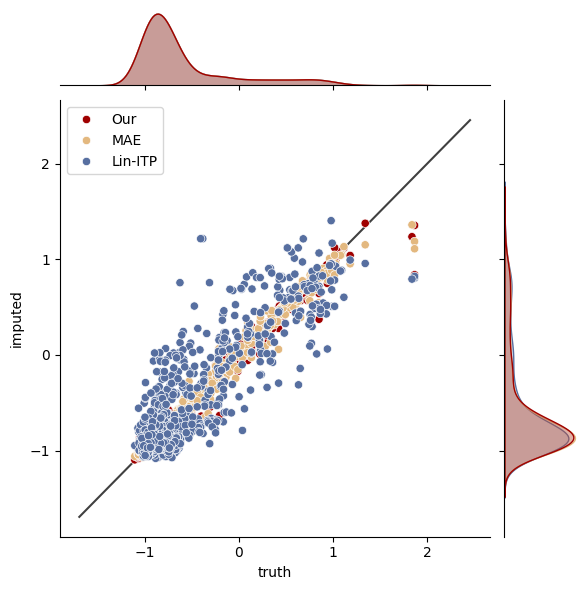

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stat
import pandas as pd
method = []
method.extend(['Our' for i in range(imputed_our.shape[0])])
method.extend(['MAE' for i in range(imputed_our.shape[0])])
method.extend(['Lin-ITP' for i in range(imputed_our.shape[0])])
data = {'truth': np.concatenate([truth.numpy() for i in range(3)]),
        'imputed':np.concatenate([imputed_our.numpy(), imputed_mae.cpu().detach().numpy(), imputed_itp.numpy()]),
        'method':method}
data = pd.DataFrame.from_dict(data)
color =["#9F0000","#e3b87f","#576fa0"]
sns.jointplot(data=data, x="truth", y="imputed", hue="method", palette=color)
# plt.scatter(truth, imputed_our,s=10, c="#9F0000",label="Our")
# plt.scatter(truth, imputed_mae.cpu().detach().numpy(),s=10, c="#e3b87f", label="MAE")
# plt.scatter(truth, imputed_itp.cpu(),s=10, c="#576fa0", label="Lin-ITP")
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, 'k-', alpha=0.75, zorder=0)
plt.legend()
print(stat.pearsonr(truth[:1000], imputed_our))
print(stat.pearsonr(truth[:1000], imputed_mae.cpu().detach().numpy()))
print(stat.pearsonr(truth[:1000], imputed_itp))

In [61]:
config.missing_ratio=0.5
from torch.utils.data import DataLoader
test_dloader = DataLoader(PRE8dDataset(config, mode='test'), 1, shuffle=True)

In [62]:
datas, data_ob_masks, data_gt_masks, labels, label_masks = next(iter(test_dloader))
device = "cuda"
datas, data_ob_masks, data_gt_masks, labels, label_masks = datas.float().to(device), data_ob_masks.to(device), data_gt_masks.to(device), labels.to(device), label_masks.to(device)

In [63]:
model = torch.load("../../log/imputation/PRE/GraphDiffusion/best_0.5.pt")
model = model.to(device)
cond_mask = data_gt_masks
adj = np.load("/home/mafzhang/data/{}/8d/adj.npy".format(config.area))
adj = torch.from_numpy(adj).float().to(device)

In [64]:
imputed_data_our = model.impute(datas, cond_mask, adj, 10)
imputed_data_our = imputed_data_our.median(1).values
mask = data_ob_masks - cond_mask
imputed_our = imputed_data_our[0][mask.bool().cpu()[0]]
truth = datas[0][mask.bool()[0]].cpu()

In [65]:
mae = torch.load("../../log/imputation/PRE/MAE/best_0.5.pt")
is_sea = np.load("/home/mafzhang/data/PRE/8d/is_sea.npy")
datas_image = torch.zeros(1,46,1,60,96)
datas_image = datas_image.to(device)
datas_image[:,:,:,is_sea.astype(bool)]=datas
cond_mask_image = torch.zeros(1,46,1,60,96)
cond_mask_image = cond_mask_image.to(device)
cond_mask_image[:,:,:,is_sea.astype(bool)]=cond_mask
imputed_data_mae = mae.impute(datas_image, cond_mask_image)
imputed_data_mae = imputed_data_mae[:,:,:,is_sea.astype(bool)]

In [66]:
imputed_mae = imputed_data_mae[0][mask.bool().cpu()[0]]

In [67]:
from einops import rearrange
import torchcde
tmp_data = torch.where(cond_mask.cpu()==0, float("nan"), datas.cpu())
tmp_data = rearrange(tmp_data, "b t c n-> (b n) t c")
itp_data = torchcde.linear_interpolation_coeffs(tmp_data)
imputed_data_itp = rearrange(itp_data, "(b n) t c -> b t c n", b=datas.shape[0], n=datas.shape[-1])

In [68]:
imputed_itp = imputed_data_itp[0][mask.bool().cpu()[0]]

In [69]:
imputed_our = imputed_our[:1000]
imputed_mae = imputed_mae[:1000]
imputed_itp = imputed_itp[:1000]
truth = truth[:1000]

PearsonRResult(statistic=0.9773570198610316, pvalue=0.0)
PearsonRResult(statistic=0.962091133706015, pvalue=0.0)
PearsonRResult(statistic=0.704198000139222, pvalue=1.294757022632167e-150)


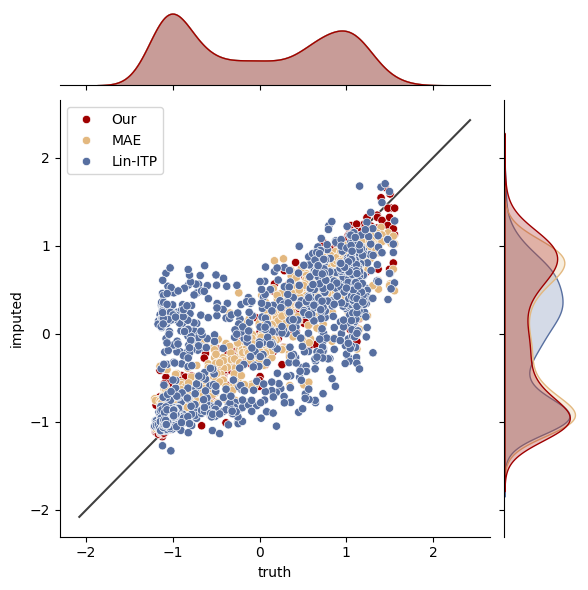

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stat
import pandas as pd
method = []
method.extend(['Our' for i in range(imputed_our.shape[0])])
method.extend(['MAE' for i in range(imputed_our.shape[0])])
method.extend(['Lin-ITP' for i in range(imputed_our.shape[0])])
data = {'truth': np.concatenate([truth.numpy() for i in range(3)]),
        'imputed':np.concatenate([imputed_our.numpy(), imputed_mae.cpu().detach().numpy(), imputed_itp.numpy()]),
        'method':method}
data = pd.DataFrame.from_dict(data)
color =["#9F0000","#e3b87f","#576fa0"]
sns.jointplot(data=data, x="truth", y="imputed", hue="method", palette=color)
# plt.scatter(truth, imputed_our,s=10, c="#9F0000",label="Our")
# plt.scatter(truth, imputed_mae.cpu().detach().numpy(),s=10, c="#e3b87f", label="MAE")
# plt.scatter(truth, imputed_itp.cpu(),s=10, c="#576fa0", label="Lin-ITP")
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, 'k-', alpha=0.75, zorder=0)
plt.legend()
print(stat.pearsonr(truth[:1000], imputed_our))
print(stat.pearsonr(truth[:1000], imputed_mae.cpu().detach().numpy()))
print(stat.pearsonr(truth[:1000], imputed_itp))

In [71]:
config.missing_ratio=0.9
from torch.utils.data import DataLoader
test_dloader = DataLoader(PRE8dDataset(config, mode='test'), 1, shuffle=True)

In [72]:
datas, data_ob_masks, data_gt_masks, labels, label_masks = next(iter(test_dloader))
device = "cuda"
datas, data_ob_masks, data_gt_masks, labels, label_masks = datas.float().to(device), data_ob_masks.to(device), data_gt_masks.to(device), labels.to(device), label_masks.to(device)

In [73]:
model = torch.load("../../log/imputation/PRE/GraphDiffusion/best_0.9.pt")
model = model.to(device)
cond_mask = data_gt_masks
adj = np.load("/home/mafzhang/data/{}/8d/adj.npy".format(config.area))
adj = torch.from_numpy(adj).float().to(device)

In [74]:
imputed_data_our = model.impute(datas, cond_mask, adj, 10)
imputed_data_our = imputed_data_our.median(1).values
mask = data_ob_masks - cond_mask
imputed_our = imputed_data_our[0][mask.bool().cpu()[0]]
truth = datas[0][mask.bool()[0]].cpu()

In [75]:
mae = torch.load("../../log/imputation/PRE/MAE/best_0.9.pt")
is_sea = np.load("/home/mafzhang/data/PRE/8d/is_sea.npy")
datas_image = torch.zeros(1,46,1,60,96)
datas_image = datas_image.to(device)
datas_image[:,:,:,is_sea.astype(bool)]=datas
cond_mask_image = torch.zeros(1,46,1,60,96)
cond_mask_image = cond_mask_image.to(device)
cond_mask_image[:,:,:,is_sea.astype(bool)]=cond_mask
imputed_data_mae = mae.impute(datas_image, cond_mask_image)
imputed_data_mae = imputed_data_mae[:,:,:,is_sea.astype(bool)]

In [76]:
imputed_mae = imputed_data_mae[0][mask.bool().cpu()[0]]

In [77]:
from einops import rearrange
import torchcde
tmp_data = torch.where(cond_mask.cpu()==0, float("nan"), datas.cpu())
tmp_data = rearrange(tmp_data, "b t c n-> (b n) t c")
itp_data = torchcde.linear_interpolation_coeffs(tmp_data)
imputed_data_itp = rearrange(itp_data, "(b n) t c -> b t c n", b=datas.shape[0], n=datas.shape[-1])

In [78]:
imputed_itp = imputed_data_itp[0][mask.bool().cpu()[0]]

In [79]:
imputed_our = imputed_our[:1000]
imputed_mae = imputed_mae[:1000]
imputed_itp = imputed_itp[:1000]
truth = truth[:1000]

PearsonRResult(statistic=0.9725404678219955, pvalue=0.0)
PearsonRResult(statistic=0.9028018741080712, pvalue=0.0)
PearsonRResult(statistic=0.7460269373320761, pvalue=2.0027440265472845e-178)


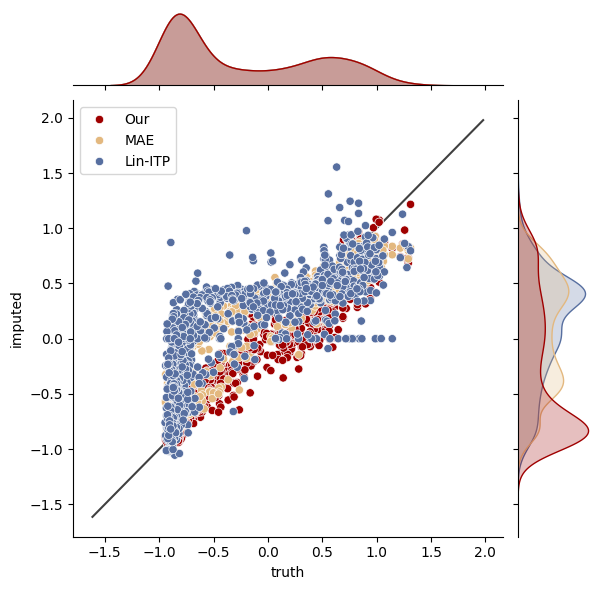

In [81]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stat
import pandas as pd
method = []
method.extend(['Our' for i in range(imputed_our.shape[0])])
method.extend(['MAE' for i in range(imputed_our.shape[0])])
method.extend(['Lin-ITP' for i in range(imputed_our.shape[0])])
data = {'truth': np.concatenate([truth.numpy() for i in range(3)]),
        'imputed':np.concatenate([imputed_our.numpy(), imputed_mae.cpu().detach().numpy(), imputed_itp.numpy()]),
        'method':method}
data = pd.DataFrame.from_dict(data)
color =["#9F0000","#e3b87f","#576fa0"]
sns.jointplot(data=data, x="truth", y="imputed", hue="method", palette=color)
# plt.scatter(truth, imputed_our,s=10, c="#9F0000",label="Our")
# plt.scatter(truth, imputed_mae.cpu().detach().numpy(),s=10, c="#e3b87f", label="MAE")
# plt.scatter(truth, imputed_itp.cpu(),s=10, c="#576fa0", label="Lin-ITP")
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, 'k-', alpha=0.75, zorder=0)
plt.legend()
print(stat.pearsonr(truth[:1000], imputed_our))
print(stat.pearsonr(truth[:1000], imputed_mae.cpu().detach().numpy()))
print(stat.pearsonr(truth[:1000], imputed_itp))